#Problème n°1

La bonne transmission de signaux électromagnétiques dans l'atmosphère peut dépendre de la météo. La pluie affecte notoirement les échanges entre les antennes relais des réseaux mobiles actuels. C'est une gêne, mais aussi une opportunité: l'atténuation des ondes électromagnétiques due à la pluie peut être mesurée et utilisée comme un moyen de quantifier les précipitations.

Dans ce problème, on s'intéresse à la conversion de l'atténuation, définie comme un rapport entre puissance émise et puissance reçue et exprimée en dB, en un taux de pluie moyen le long de segments physiques dont les extrémités sont des paires d'antennes relais.

Evidemment, d'autres éléments que le pluie, plus ou moins bien connus, peuvent influencer l'atténuation. La simulation sur laquelle nous allons travailler, qui porte sur un millier de paires d'antennes virtuelles, est construite de la façon suivante:

- pour une paire d'antennes donnée, on modélise une série temporelle de taux de pluie moyen par un processus stochastique dont les paramètres dépendent entre autres de la distance qui sépare les antennes.
- pour en tirer des atténuations, on applique à cette série les transformations suivantes:
    - un filtre convolutif, censé modéliser l'impact du film d'eau se formant sur les antennes au cours d'un épisode de pluie.
    - une conversion non-linéaire, tirée d'un modèle physique, est appliquée composante à composante.
 épisode pluvieux (ce film qui s'épaissit augmente progressivement l'atténuation).
    - un bruit haute-fréquence
    - un bruit basse fréquence

La cellules suivantes permettent de récupérer les briques de code utiles, de construire un dictionnaire contenant des identifiants de paires d'antennes (clefs) et les distances les séparant (valeurs). La dernière cellule montre des exemples de séries temporelles simulées pour quelques paires.

In [1]:
# Local clone
! git clone https://github.com/emiledevos/exam_2025.git
! cp exam_2025/utils/utils_probleme1.py .

Cloning into 'exam_2025'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 59 (delta 21), reused 20 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 1.41 MiB | 3.00 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np
import sys
from utils_probleme1 import create_dataloader

In [17]:
# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création du dataloader (il contient toutes les étapes de la simulation)
# (en une époque, chaque paire d'antennes du dictionnaire idx2distance
# a été tirée exactement une fois)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)

# Génération d'un batch contenant des séries temporelles
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

torch.Size([4096])


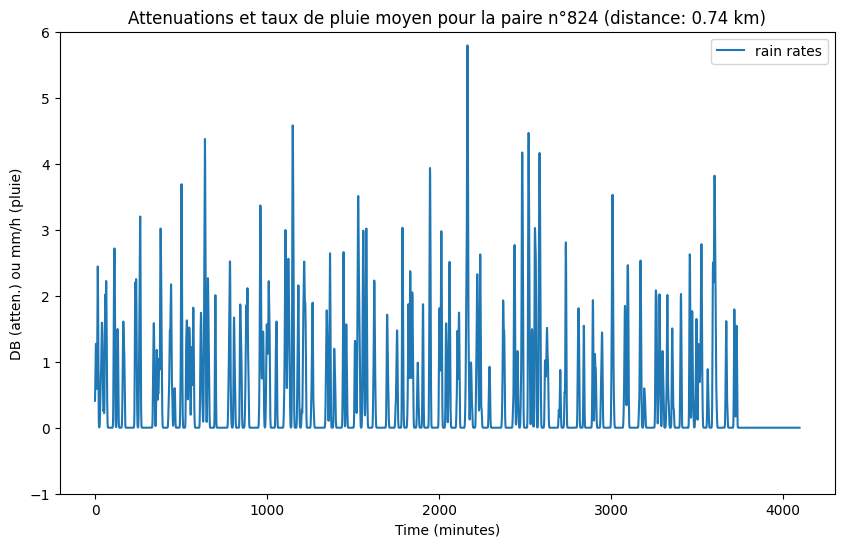

torch.Size([4096])


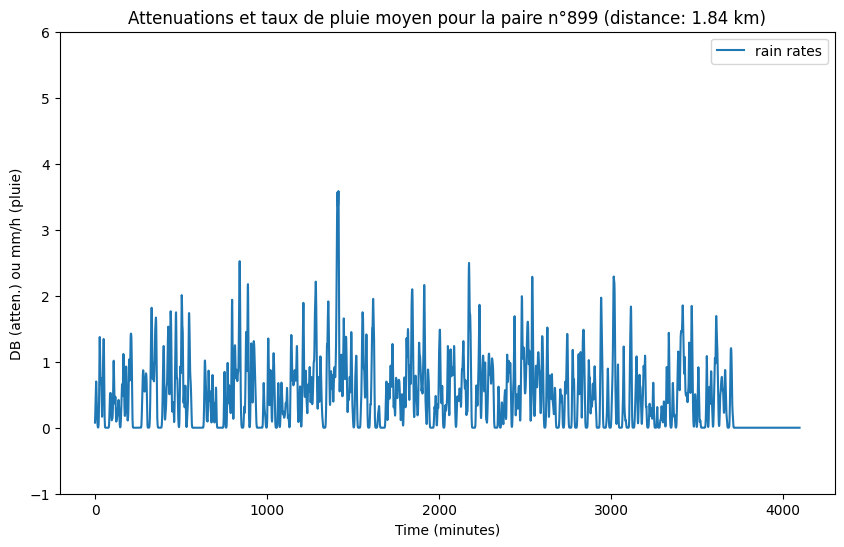

torch.Size([4096])


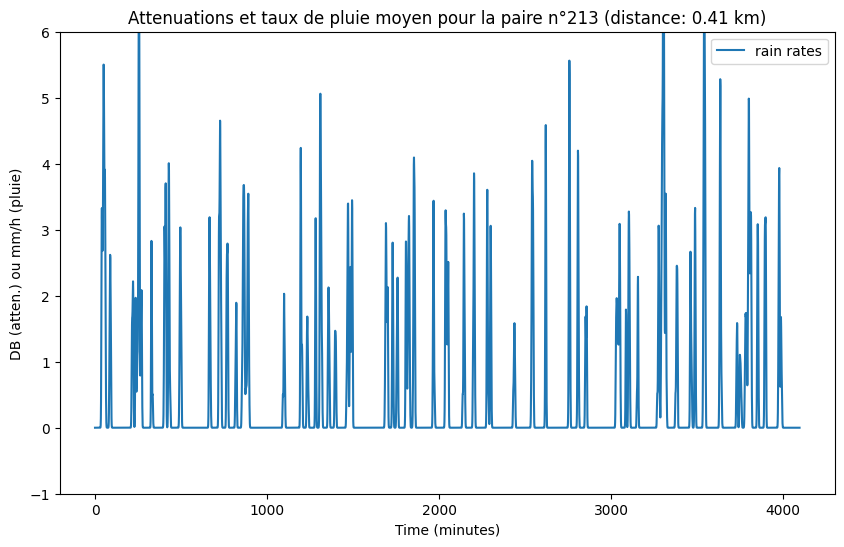

torch.Size([4096])


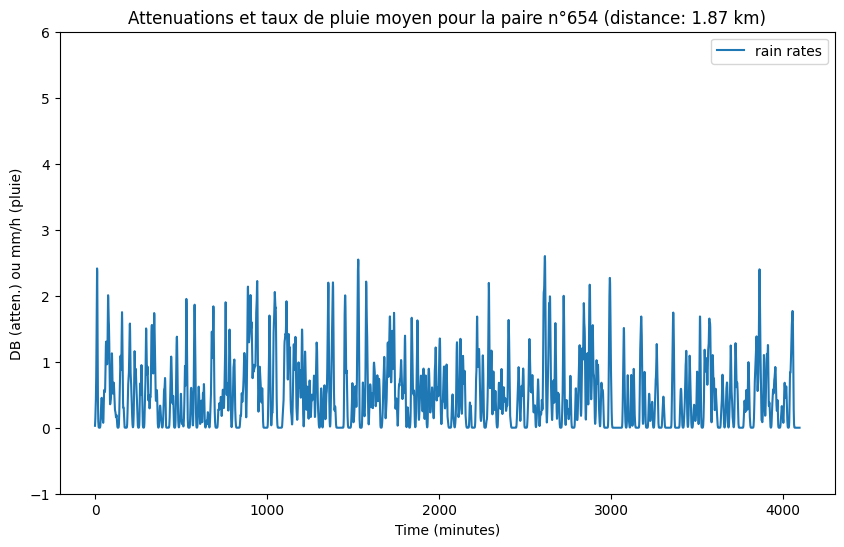

torch.Size([4096])


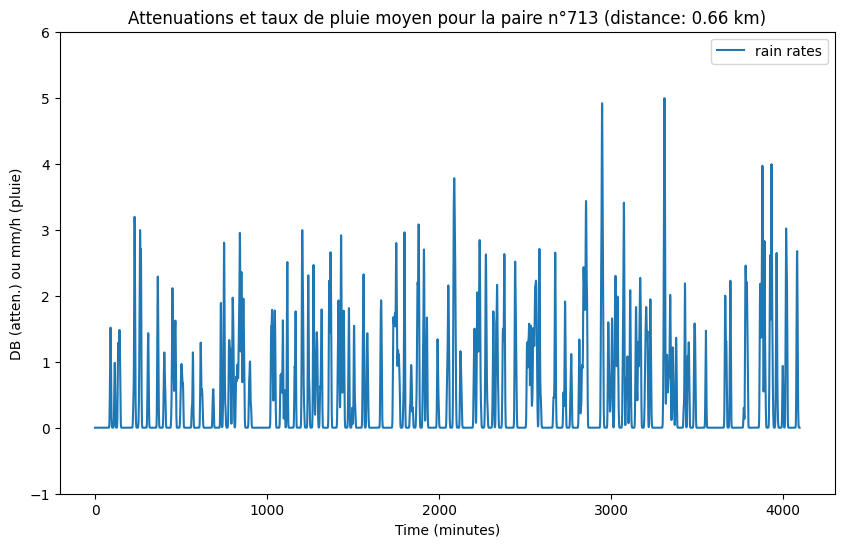

In [23]:

import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k], label='attenuations')
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

## Partie I : Un réseau de neurones générique

# A partir des briques de base

Dans cette partie, on entraîne un UNet1D à faire le lien entre atténuations
et taux de pluie. Les cellules suivantes contiennent les blocs du UNet1D et son montage :

In [5]:
##############################################################################################
################################     UNet 1D building blokcs    ##############################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


################################################################################
######################################## class UNet1D ##########################

class UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x

**Consignes:** \
1) Entraîner sur GPU un UNet 1D à restituer les taux de pluie à partir des atténuations.
- On utilisera la MSE comme fonction de coût et comme score. Dans les deux cas, prendre une marge de deux heures au début et à la fin de la série temporelle pour éviter les effets de bord.
- La descente de gradient stochastique sera pilotée par l'optimiseur ADAM (paramétrage standard) sur cinquante époques.

2) Tracer la courbe d'apprentissage de manière à montrer l'évolution:
- des performances en généralisation sur de nouvelles données issues des paires d'antennes vues à l'entraînement.
- des performances en généralisation sur des séries issues de paires d'antennes indépendantes (celles de *idx2distance_val*).


3) Visualiser les prédictions après apprentissage

Epoch 1/50, Train Loss: 0.7364, Val Loss: 0.7488
Epoch 2/50, Train Loss: 0.3119, Val Loss: 0.7821
Epoch 3/50, Train Loss: 0.1775, Val Loss: 0.7146
Epoch 4/50, Train Loss: 0.1576, Val Loss: 0.6026
Epoch 5/50, Train Loss: 0.1519, Val Loss: 0.3521
Epoch 6/50, Train Loss: 0.1477, Val Loss: 0.1915
Epoch 7/50, Train Loss: 0.1439, Val Loss: 0.1742
Epoch 8/50, Train Loss: 0.1418, Val Loss: 0.1616
Epoch 9/50, Train Loss: 0.1478, Val Loss: 0.1475
Epoch 10/50, Train Loss: 0.1397, Val Loss: 0.1413
Epoch 11/50, Train Loss: 0.1423, Val Loss: 0.1425
Epoch 12/50, Train Loss: 0.1398, Val Loss: 0.1447
Epoch 13/50, Train Loss: 0.1357, Val Loss: 0.1492
Epoch 14/50, Train Loss: 0.1392, Val Loss: 0.1443
Epoch 15/50, Train Loss: 0.1373, Val Loss: 0.1524
Epoch 16/50, Train Loss: 0.1370, Val Loss: 0.1451
Epoch 17/50, Train Loss: 0.1362, Val Loss: 0.1441
Epoch 18/50, Train Loss: 0.1386, Val Loss: 0.1341
Epoch 19/50, Train Loss: 0.1370, Val Loss: 0.1375
Epoch 20/50, Train Loss: 0.1359, Val Loss: 0.1346
Epoch 21/

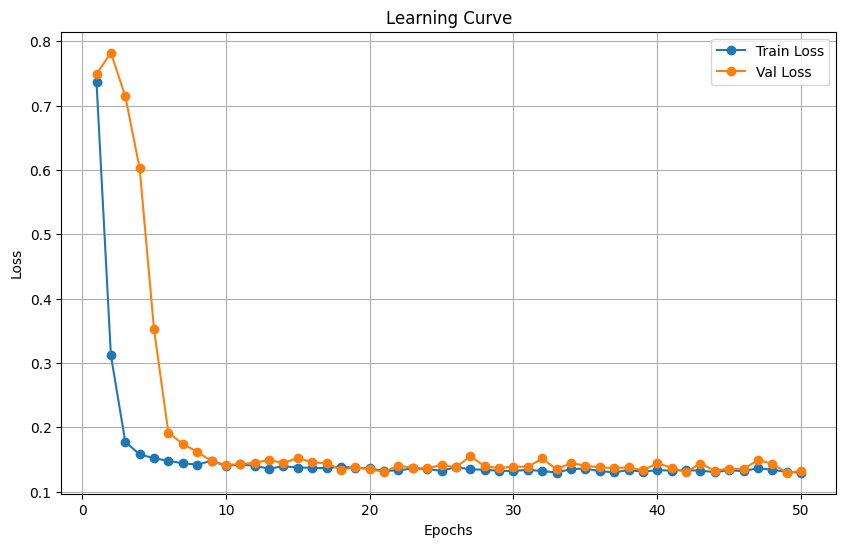

In [88]:
import torch.optim as optim
from torch.nn import MSELoss
n_channels = 1  # Exemple : une seule entrée (un signal 1D)
n_classes = 1   # Exemple : prédire un seul taux de pluie
batch_size = 32
epochs = 50
lr = 0.001      # Taux d'apprentissage

model = UNet1D(n_channels, n_classes, size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_losses = []
val_losses = []
criterion = nn.MSELoss() #definitions de la fonction de loss
optimizer = optim.Adam(model.parameters(), lr=lr)

# Création du DataLoader pour la validation
valloader = create_dataloader(duration, idx2distance_val, batch_size)

# entrainement et validation pour chaque epoch.
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for ids, dists, rain_rates, attenuations in trainloader:
        attenuations,rain_rates = attenuations.to(device),rain_rates.to(device)
        optimizer.zero_grad()

        outputs = model(attenuations.unsqueeze(1))

        loss = criterion(outputs[:, 0, 120:-120], rain_rates[:, 120:-120])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


    avg_train_loss = train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Val
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
            attenuations = attenuations.to(device)
            rain_rates = rain_rates.to(device)

            optimizer.zero_grad()

            outputs = model(attenuations.unsqueeze(1))

            loss = criterion(outputs[:, 0, 120:-120], rain_rates[:, 120:-120])
            val_loss += loss.item()

        avg_val_loss = val_loss / len(valloader)
        val_losses.append(avg_val_loss)  # Stocker la loss de validation

    # Affichage des pertes
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    model.train()

print("Entraînement terminé.")

# Tracé des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()




RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [32, 1, 1, 1, 1, 1, 4096]

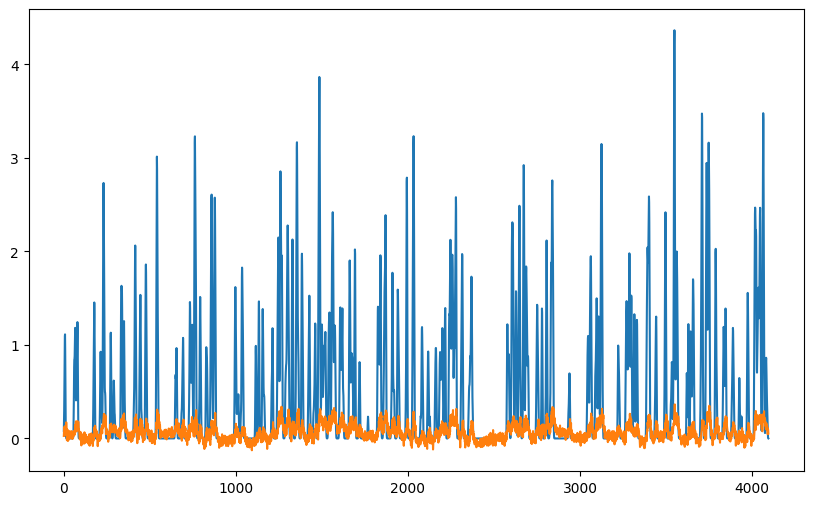

In [49]:
import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k].cpu().numpy().squeeze(), label='attenuations') # Move tensor to CPU before converting to NumPy
  prediction = model(attenuations)
  plt.plot(np.arange(duration), predictions[k].cpu().detach().numpy(), label='predictions') # Move prediction to CPU and detach before converting to NumPy
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

Je ne comprends pas pourquoi je n'arrive pas a afficher la sortie de mon modèle


## Partie II

Dans la première partie, le modèle était générique: la specificité de la paire d'antenne n'était pas prise en compte. On se propose de le faire en combinant un réseau générique à un perceptron spécifique, de sorte que la sortie $Z$ s'exprime sous la forme: \
$$Z = F(X, k) = f^{\tiny{Perceptron}}_{\alpha_k}(f^{\tiny{UNet}}_{\theta}(X))$$ \
 où $f^{\tiny{UNet}}_{\theta}(.)$ représente la fonction *forward* d'un UNet et $f^{\tiny{Perceptron}}_{\alpha_k}(.)$, la fonction forward du perceptron associé à la paire d'antennes d'identifiant $k$. \

Il s'agit donc en premier lieu d'adjoindre au UNet de la partie I autant de perceptrons que le jeu d'entraînement compte de paires d'antennes, ce qui se fait grâce aux lignes suivantes:

In [36]:
# Pour l'ajout de 1200 perceptrons à deux couches:
self.num_pairs = 1200
self.input_size_fc_layer = 5
self.hidden_size_fc_layer = 5
# Liste des premières couches
self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])
# Liste des secondes couches
self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                         1) for i in range(self.num_pairs)])


NameError: name 'self' is not defined

In [100]:
import torch.nn.functional as F
class UNet1D_avec_Perceptrons(nn.Module):
    def __init__(self, n_channels, n_classes, num_pairs, input_size_fc_layer=5, hidden_size_fc_layer=5, size=64):
        super(UNet1D_avec_Perceptrons, self).__init__()

        # Définition du UNet comme dans l'implémentation originale
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)

        # Définition des perceptrons (2 couches)
        self.num_pairs = num_pairs
        self.input_size_fc_layer = input_size_fc_layer
        self.hidden_size_fc_layer = hidden_size_fc_layer

        # Liste des premières couches (pour chaque paire d'antennes)
        self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer, self.hidden_size_fc_layer) for _ in range(self.num_pairs)])

        # Liste des secondes couches (pour chaque paire d'antennes)
        self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer, 1) for _ in range(self.num_pairs)])

        self.n_classes = n_classes
        self.num_pairs = num_pairs

    def forward(self, x, ids):
        """
        x: Entrée de taille (batch_size, n_channels, sequence_length)
        ids: Identifiants des paires d'antennes pour lesquelles appliquer le perceptron spécifique
        """
        # Passer les données à travers le UNet
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        output = self.apply_perceptron(x, ids)
        return output
    def apply_perceptron(self, UNet_output, ids):

      for i in range(ids.shape[0]):
          id = ids[i]
          # application de la première couche
          x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
          x = F.relu(x)
          # application de la seconde couche
          x = self.linears2[id](x)
          # correction multiplicative de UNet_output
          UNet_output[i, 0] *= 1 + x.transpose(0,1).contiguous().squeeze()
      return UNet_output[:,0]



JE N'AI PAS REUSSI A OUVRIR LE FICHIER UTIL_PBM1 AVEC GOOGLE COLLAB

On va redefinir une nouvelle classe pour le UNET1D_avec_perceptron. pour ce faire, on commence par reprendre le meme fichier d'initialisation et de forward que le UNET1D donné dans l'énoncé.
POur cela, on commence par recopier les lignes de codes donnée afin de définir une liste de couche de neurones complement connecter. ON en a k diferents. un pour chaque entaine.

Ceci est ainsi ajouté a la partie "init".

Ensuite, on va utiliser ces ajous dans la partie forward. si elle est au départ identique, car on applique les memes réseau de convolution. On doit ensuite appliquer seulement

**Consignes:** \
1) Définir une nouvelle classe de réseau en modifiant la classe UNet1D (dans utils_probleme1.py).
Ajouter ces perceptrons au réseau.

Réponse:
JE N'AI PAS REUSSI A OUVRIR LE FICHIER UTIL_PBM1 AVEC GOOGLE COLLAB

On va redefinir une nouvelle classe pour le UNET1D_avec_perceptron. pour ce faire, on commence par reprendre le meme fichier d'initialisation et de forward que le UNET1D donné dans l'énoncé.
POur cela, on commence par recopier les lignes de codes donnée afin de définir une liste de couche de neurones complement connecter. ON en a k diferents. un pour chaque entaine.

Ceci est ainsi ajouté a la partie "init".


2) Fixer *self.n_classes* de façon à ce que la sortie du UNet soit compatible avec l'entrée du perceptron.

3) Modifications de la fonction forward:
- elle doit prendre comme arguments un batch d'entrées et un batch d'identifiants.

- après les étapes propres au UNet, elle doit appliquer le perceptron d'indice k à une série provenant de la paire n°k. La cellule de code suivante fournit un exemple dont on pourra directement s'inspirer.

4) Suivre les performances en généralisation sur les paires d'antennes du jeu d'entraînement et sur les deux cents paires de validation. Commenter.




In [86]:
torch.cuda.empty_cache()

Epoch 1/30:
Train Loss: 0.298212
Val Loss: 0.638176
Epoch 2/30:
Train Loss: 0.222103
Val Loss: 0.238403
Epoch 3/30:
Train Loss: 0.216892
Val Loss: 0.251896
Epoch 4/30:
Train Loss: 0.217803
Val Loss: 0.240520
Epoch 5/30:
Train Loss: 0.210561
Val Loss: 0.219917
Epoch 6/30:
Train Loss: 0.207142
Val Loss: 0.212817
Epoch 7/30:
Train Loss: 0.198887
Val Loss: 0.214921
Epoch 8/30:
Train Loss: 0.197521
Val Loss: 0.203506
Epoch 9/30:
Train Loss: 0.200972
Val Loss: 0.216583
Epoch 10/30:
Train Loss: 0.196972
Val Loss: 0.222534
Epoch 11/30:
Train Loss: 0.200252
Val Loss: 0.205003
Epoch 12/30:
Train Loss: 0.194032
Val Loss: 0.199328
Epoch 13/30:
Train Loss: 0.191923
Val Loss: 0.253621
Epoch 14/30:
Train Loss: 0.188959
Val Loss: 0.215332
Epoch 15/30:
Train Loss: 0.188647
Val Loss: 0.205901
Epoch 16/30:
Train Loss: 0.186424
Val Loss: 0.209361
Epoch 17/30:
Train Loss: 0.186528
Val Loss: 0.210202
Epoch 18/30:
Train Loss: 0.183630
Val Loss: 0.220468
Epoch 19/30:
Train Loss: 0.183460
Val Loss: 0.214606
Ep

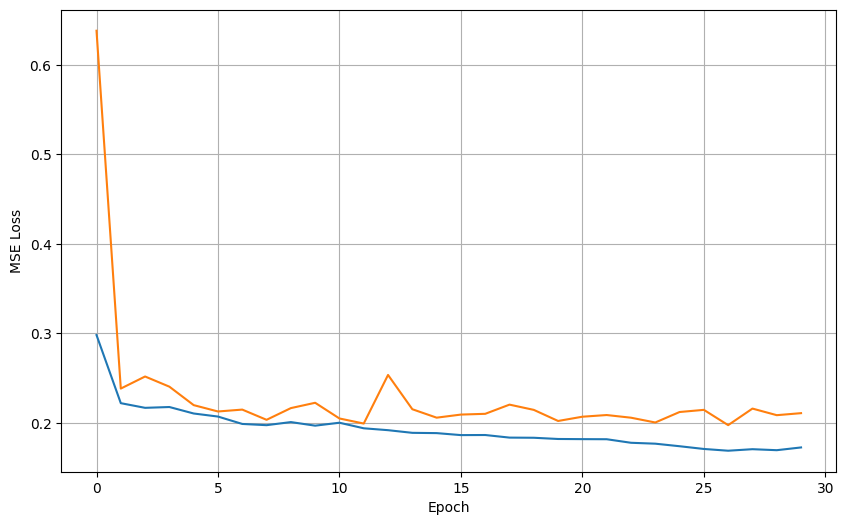

In [102]:
def Validation_Du_Modele(model, trainloader, valloader, n_epochs, device, margin=120):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # Entrainement
        model.train()
        epoch_loss = 0

        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
            optimizer.zero_grad()

            ids = ids.to(device)
            attenuations = attenuations.unsqueeze(1).to(device)
            rain_rates = rain_rates.to(device)

            outputs = model(attenuations, ids)
            loss = criterion(outputs[:, 120:-120], rain_rates[:, 120:-120])

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(trainloader))

        # Validation
        model.eval()
        val_loss = 0


        with torch.no_grad():
            for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
                ids = ids.to(device)
                attenuations = attenuations.unsqueeze(1).to(device)
                rain_rates = rain_rates.to(device)

                outputs = model(attenuations, ids)
                loss = criterion(outputs[:, margin:-margin], rain_rates[:, margin:-margin])

                val_loss += loss.item()

        val_losses.append(val_loss / len(valloader))

        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Train Loss: {train_losses[-1]:.6f}')
        print(f'Val Loss: {val_losses[-1]:.6f}')

    return train_losses, val_losses


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet1D_avec_Perceptrons(n_channels=1, n_classes=5, num_pairs=1200).to(device)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)
valloader = create_dataloader(duration, idx2distance_val, batch_size)

train_losses, val_losses,  = Validation_Du_Modele(
    model, trainloader, valloader, n_epochs=30, device=device
)


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

plt.grid(True)
plt.show()

## Partie III

La solution proposée dans la partie II a un défaut: les performances chutent sur les paires d'antennes qui n'ont pas été rencontrées pendant l'entraînement. Pour le corriger, on se propose de suivre la méthode suivante:
- ajouter un perceptron "générique" de même architecture que les perceptrons spécifiques.
- entraîner le réseau de la partie II en remplaçant une fois sur quatre l'identifiant de la paire d'antennes par l'indice du perceptron générique.
- après cinquante époques, geler les poids de la partie générique et prolonger l'apprentissage des perceptrons spécifiques sur une vingtaine d'époque.

**Consignes:** \

1) Mettre en oeuvre cette méthode

2) Conclure sur son efficacité